In [ ]:
# #download the dataset
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip flickr-image-dataset.zip

In [1]:
# loading our caption file
import pandas as pd
df = pd.read_csv("./flickr30k_images/results.csv", delimiter="|")
df.columns = ["image_name","caption_number","caption"]

#some data correction
df.loc[19999, 'caption_number'] = "4"
df.loc[19999, 'caption'] = "A dog runs across the grass ."

# same id for same image, there are 5 captions per image
df["id"] = [id_ for id_ in range(len(df)//5) for _ in range(5)] 
df.caption = df.caption.str.strip()
df.head()

,image_name,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


In [2]:

# let's divide our dataset into train and validation dataset
# we want the same image with all its captions to be in either train or valid dataset
import numpy as np
ids = df["id"].unique()
np.random.shuffle(ids)
split_size = 0.8
train_ids = ids[:int(split_size*len(ids))]
valid_ids = ids[int(split_size*len(ids)):]
train_df = df[df.id.isin(train_ids)]
valid_df = df[df.id.isin(valid_ids)]

In [3]:
# we will be using pretrained tokenizer
# distilbert is fast and encoder only block so suitalble for our case as we want rich representation of our text
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [4]:
#dataset preparation

import torch
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
valid_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()])

class Clip_Dataset(Dataset):
    def __init__(self,data, transforms):
        self.image_filenames= data.image_name.values
        self.captions = list(data.caption.values)
        encoded_captions = tokenizer(list(data.caption.values),padding= True, truncation=True, max_length=200)
        self.input_ids = encoded_captions["input_ids"]
        self.attention_mask  = encoded_captions["attention_mask"]
        self.transforms  = transforms 
    def __getitem__(self,idx):
        filename= self.image_filenames[idx]
        image = Image.open("./flickr30k_images/flickr30k_images/"+ filename) 
        item = {}
        item["image"] = self.transforms(image)
        item["caption"] = self.captions[idx]
        item["input_ids"] = torch.tensor(self.input_ids[idx])
        item["mask"] = torch.tensor(self.attention_mask[idx])
        return item
    def __len__(self):
        return len(self.captions)
        

In [5]:
train_data = Clip_Dataset(train_df,train_transforms)
valid_data = Clip_Dataset(valid_df,valid_transforms)

In [6]:
# import matplotlib.pyplot as plt
# plt.imshow(valid_data[30]['image'].permute(1,2,0))
# plt.title(valid_data[30]['caption'])

In [7]:
# data loaders
import os
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,batch_size=32,num_workers=os.cpu_count()-1,shuffle=True,pin_memory=True)
valid_loader = DataLoader(valid_data,batch_size=32,num_workers=2,shuffle=False,pin_memory=True)

In [8]:
import torch.nn as nn
import timm
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("resnet50",pretrained=True,num_classes=0,global_pool="avg")
        for p in self.model.parameters():
            p.requires_grad = True
    def forward(self,x):
        return self.model(x)

In [9]:
from transformers import DistilBertModel
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        for p in self.model.parameters():
            p.requires_grad = True
        self.target_token_idx = 0
    def forward(self,input_ids, attention_mask):
        output= self.model(input_ids= input_ids, attention_mask= attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:,self.target_token_idx,:]
    

In [10]:
# we want to convert the final output of image encoder and text encoder to same dimensions

class ProjectionHead(nn.Module):
    def __init__(self,embed_dim, proj_dim, dropout=0.1):
        super().__init__()
        self.projection = nn.Linear(embed_dim, proj_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(proj_dim, proj_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(proj_dim)
    def forward(self,x):
        projected = self.projection(x)
        x = self.dropout(self.fc(self.gelu(projected)))
        x = x + projected
        x = self.layer_norm(x)
        return x
        

In [11]:
# we will be using pytorch lightning to design our model 
# as it simplifies training, design and logging

import lightning as L
import torch.nn.functional as F

class Clip_model(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(2048,256)
        self.text_projection = ProjectionHead(768,256)
        
    def forward(self,x):
        images = self.image_encoder(x["image"])
        texts = self.text_encoder(x["input_ids"],x["mask"])
        image_embed = self.image_projection(images)
        text_embed = self.text_projection(texts)
        logits = text_embed @ image_embed.T
        targets = torch.eye(logits.size(0)).to(logits.device) # batch_size x batch_size
        loss = torch.sum(-F.log_softmax(logits,dim=-1) * targets)
        return loss.mean()
    def training_step(self,batch,batch_idx):
        loss= self.forward(batch)
        self.log("train_loss",loss,on_step=True,on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self,batch,batch_idx):
        loss= self.forward(batch)
        self.log("valid_loss",loss,on_epoch=True, prog_bar=True)
        return loss
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(),lr=3e-4)

In [12]:
model = Clip_model()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
from lightning import Trainer
torch.set_float32_matmul_precision("medium")
trainer = Trainer(max_epochs=2)
trainer.fit(model,train_loader,valid_loader)
#torch.save(model.state_dict(),"clip_model.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | image_encoder    | ImageEncoder   | 23.5 M
1 | text_encoder     | TextEncoder    | 66.4 M
2 | image_projection | ProjectionHead | 590 K 
3 | text_projection  | ProjectionHead | 263 K 
----------------------------------------------------
90.7 M    Trainable params
0         Non-trainable params
90.7 M    Total params
362.900   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [15]:
model.load_state_dict(torch.load("clip_model.pth"))

<All keys matched successfully>

In [18]:
# we are getting all the valid dataset image embedding to find the max similarity images with our text query
model.eval()
valid_image_embeddings = []
i=0
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
with torch.no_grad():
    if i%100==0:
        print(i)
    for batch in valid_loader:
        image_features = model.image_encoder(batch["image"].to(device))
        image_embeddings = model.image_projection(image_features)
        valid_image_embeddings.append(image_embeddings)
        i+=1
image_embeddings = torch.cat(valid_image_embeddings,dim=0)

cuda
0


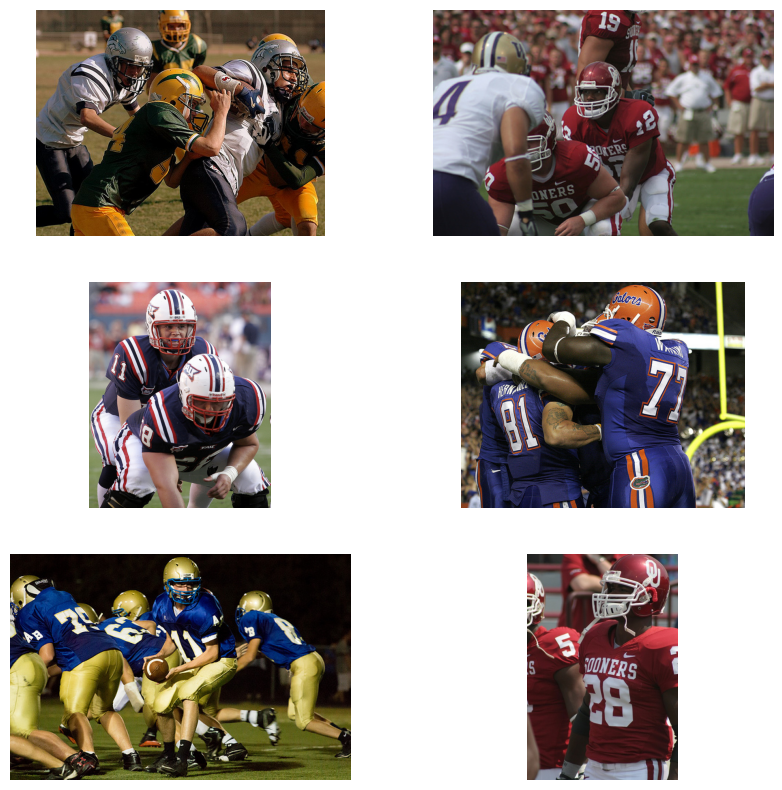

In [19]:
#inference
import matplotlib.pyplot as plt 
query = "football"
encoded_query = tokenizer([query])
image_filenames= valid_df["image_name"].values
n= 6
batch = {"input_ids": torch.tensor(encoded_query["input_ids"]).to(device),
         "attention_mask":torch.tensor(encoded_query["attention_mask"]).to(device)}
with torch.no_grad():
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projection(text_features)

# similarity score with each of the images
dot_similarity = text_embeddings @ image_embeddings.T


values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
matches = [image_filenames[idx] for idx in indices[::5]] # steps of 5 as 5 captions per image

_, axes = plt.subplots(3, 2, figsize=(10, 10))
for match, ax in zip(matches, axes.flatten()):
    try:
        image = Image.open("./flickr30k_images/flickr30k_images/"+ match)
        image = np.array(image)
        ax.imshow(image)
        ax.axis("off")
    except: # if image not in our subset of validation dataset
        continue

plt.show()
